# Video processing using 3DCNN


**Our Agenda:**
0. Understanding the data, file (and path) structure.
1.  **Setup & Data Loading**: Prepare our environment and the UCF101 dataset.
2.  **Model Building**: Create a 3D CNN class.
3.  **Model Inspection with torchsummary**: Understand our network's architecture, layer outputs, and parameter counts.
4.  **Experiments**: Train, validation and testing, along with saving and loading checkpoints.
5.  **Results Analysis**: Results such as accuracy, precision, recall, F1-score and confusion matrix.

# Step 0: Understanding data and file structure

Data and file structure vary between dataset. Thus, it is very much important to understand the data and file structure first.

# UCF101 dataset:

1. 13,320 videos, **101 human action classes** (sports, music, interactions, daily activities).
2. Videos grouped into 5 categories: sports, body motion, human-object interaction, human-human interaction, musical instruments.
3. Each video: 320×240 resolution, ~27 hours total length.
4. Provides 3 official train/test splits (~9.5k train, ~3.7k test per split).

Full dataset link: https://www.crcv.ucf.edu/data/UCF101.php


Here, we have chosen few videos from classes:

CricketShot, PlayingCello, Punch, ShavingBeard and TennisSwing.

Link: https://drive.google.com/file/d/1F2PN4eEaACAMJGbcDLSiCmQe8lT2Y3um/view

File structure:

1. Video path:
Two folders, train and test, containing .avi files.

2. CSV files:
Two .csv files, train.csv and test.csv, which contain the classes for the videos. "video_name" field shows file name and "tag" shows the class.

CSV data:

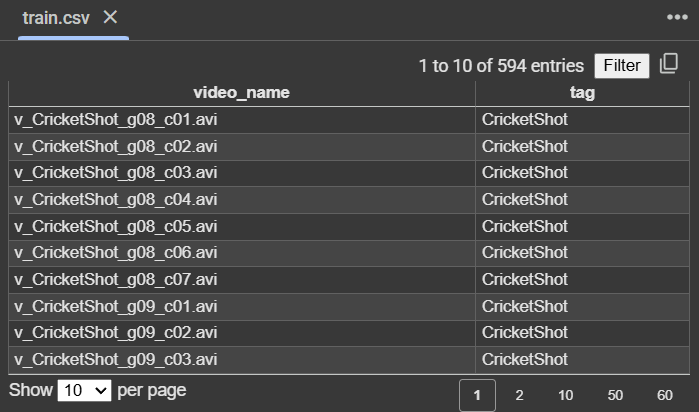

## Step 1: Setup & Data Loading:


 Import Libraries and Setup

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Load and Prepare UCF101  Dataset


In [3]:
# Function for loading and preprocessing dataset

class VideoDataset(Dataset):
    def __init__(self, csv_file, videos_dir, num_frames=16, frame_size=(112,112)):
        """
        Args:
            csv_file (str): Path to CSV file containing video names and labels
            videos_dir (str): Path to directory containing video files
            num_frames (int): Number of frames to sample per video
            frame_size (tuple): Desired (height, width) of each frame
        """
        # Load CSV file that contains columns [video_name, tag]
        self.data = pd.read_csv(csv_file)
        self.videos_dir = videos_dir
        self.num_frames = num_frames
        self.frame_size = frame_size

        # Create label-to-index mapping (e.g. {'class1':0, 'class2':1, ...})
        classes = sorted(self.data['tag'].unique())
        self.label2idx = {c:i for i,c in enumerate(classes)}
        self.idx2label = {i:c for c,i in self.label2idx.items()}  # reverse mapping

    def __len__(self):
        # Return total number of samples
        return len(self.data)

    def _read_video(self, path):
        """
        Reads a video file, samples self.num_frames frames,
        resizes them, and converts to a PyTorch tensor.
        """
        cap = cv2.VideoCapture(path)  # open video
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # total number of frames
        indices = np.linspace(0, max(total-1,0), self.num_frames).astype(int)  # sample evenly spaced frames

        frames = []
        i, grabbed = 0, 0
        while True:
            ret, frame = cap.read() # if frame is read correctly ret is True
            if not ret:
              break  # stop if no frame is read
            if i in indices:   # check if current frame is in selected indices
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # convert BGR → RGB
                frame = cv2.resize(frame, self.frame_size)      # resize frame
                frames.append(frame)
                grabbed += 1
                if grabbed == self.num_frames:
                  break  # stop once enough frames are collected
            i += 1
        cap.release() # When everything done, release the capture

        # If video had fewer frames, duplicate last frame until required length
        while len(frames) < self.num_frames:
            frames.append(frames[-1].copy())

        # Normalize pixel values to [0,1] and change format to (C,T,H,W)
        arr = np.stack(frames).astype(np.float32) / 255.0   # (T,H,W,C)
        arr = np.transpose(arr, (3,0,1,2))                  # (C,T,H,W)
        return torch.tensor(arr)

    def __getitem__(self, idx):
        """
        Returns:
            video (Tensor): (C,T,H,W) tensor of sampled frames
            label (int): Class index
        """
        row = self.data.iloc[idx]
        video_path = os.path.join(self.videos_dir, row['video_name'])
        label = self.label2idx[row['tag']]
        return self._read_video(video_path), label


Train and Validation dataloader

In [4]:
from torch.utils.data import random_split

# Path to train CSV file and video directory
csv_file = "train.csv"
videos_dir = "train"

# Create full dataset
full_ds = VideoDataset(csv_file, videos_dir, num_frames=16)

# Define split ratio
train_ratio = 0.8   # 80% train, 20% validation
val_ratio   = 1 - train_ratio

# Compute lengths
train_size = int(train_ratio * len(full_ds))
val_size   = len(full_ds) - train_size

# Random split
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

# Wrap datasets in DataLoader for batching and shuffling
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False)

num_classes = len(full_ds.label2idx)


print(f"Number of class: {num_classes}")

Number of class: 5


Test dataloader

In [5]:
# Path to test CSV file and video directory
test_csv = "test.csv"      # Path to test csv
test_dir = "test"          # Path to test videos

# Create test dataset
test_ds = VideoDataset(test_csv, test_dir, num_frames=16)
# Wrap datasets in DataLoader for batching and shuffling
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False)

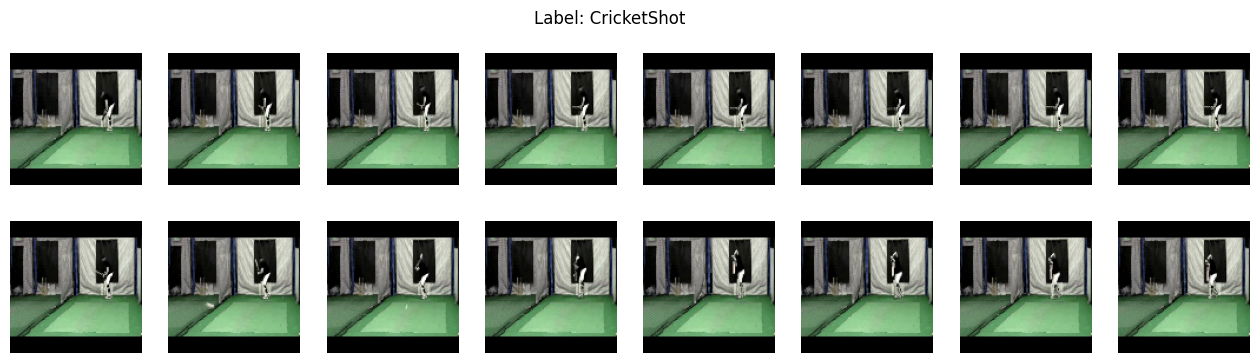

In [6]:
# Show an example video sequence

# Get first sample from dataset
X, y = full_ds[0]  # X: (C,T,H,W), y: label index

# Rearrange dimensions for visualization → (T,H,W,C)
frames = X.permute(1,2,3,0).numpy()  # (T,H,W,C)

# Plot sampled frames in a grid
fig, axes = plt.subplots(2,8,figsize=(16,4))  # 2 rows × 8 frames
for i, ax in enumerate(axes.flatten()):
    ax.imshow(frames[i])
    ax.axis("off")

# Display corresponding label
plt.suptitle(f"Label: {full_ds.idx2label[y]}")
plt.show()

In [7]:
from IPython.display import Video
import numpy as np
import cv2

def save_video(frames, path="sample_video.mp4", fps=16):
    """
    Save a tensor video to an MP4 file and display it in the notebook.

    Args:
        frames (torch.Tensor): Video tensor of shape [C, T, H, W]
        path (str): Output path for the saved video file
        fps (int): Frames per second for playback
    """
    # Convert from (C, T, H, W) → (T, H, W, C) and move to numpy
    frames = frames.permute(1, 2, 3, 0).cpu().numpy()

    # Ensure frames are uint8 in [0,255] (if normalized in [0,1], rescale)
    if frames.max() <= 1.0:
        frames = (frames * 255).astype(np.uint8)
    else:
        frames = frames.astype(np.uint8)

    # Get video dimensions (H,W)
    h, w = frames[0].shape[:2]
    print(f"Saving {len(frames)} frames of size ({h}, {w})")

    # Initialize OpenCV video writer
    writer = cv2.VideoWriter(
        path,
        cv2.VideoWriter_fourcc(*"mp4v"),  # MP4 codec
        fps,
        (w, h)
    )

    # Write each frame
    for frame in frames:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert RGB→BGR
        writer.write(frame_bgr)

    writer.release()
    print(f"Video saved at {path}")

    return Video(path, embed=True)


# Example usage
video, label = next(iter(train_loader))  # get one batch
save_video(video[0])         # show first video in batch


Saving 16 frames of size (112, 112)
Video saved at sample_video.mp4


In [24]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def display_video(path):
    """
    Display an MP4 inline in Jupyter/Colab using matplotlib animation.

    Args:
        path (str): Path to the video file
    Returns:
        HTML object that plays the video inline in a notebook.
    """
    # Load the video
    video = imageio.mimread(path)

    fig = plt.figure(figsize=(3, 3))
    mov = []

    # Add video frames one by one
    for frame in video:
        img = plt.imshow(frame, animated=True)  # show image as animation
        plt.axis('off')
        mov.append([img])

    # Build animation
    anime = animation.ArtistAnimation(
        fig,
        mov,
        interval=62.5,         # frame duration in ms (~16 FPS here)
        repeat_delay=1000    # delay before repeating video (in ms)
    )

    plt.close()

    # Return as HTML5 video
    return HTML(anime.to_html5_video())


display_video('sample_video.mp4')

# Step 2: Implementation of 3D CNN

Model details:

* Input Shape: (B, 3, T, H, W)

* Feature Extractor (3 Layers, dimension reduction factor: 1/8 in T, H, W):

1. Conv3D layers (channel dimension: 32, 64, 128) with ReLU activations

2. MaxPool3D after each Conv layer (downsampling in time + space)

* Fully Connected Layers:

1. Flattened features → Dense layer (512 units) + ReLU + Dropout(0.5)

2. Final dense layer → num_classes outputs (logits)

* Output: (B, num_classes) (class scores for each video)


In [8]:
class VideoCNN(nn.Module):
    def __init__(self, num_classes, num_frames=16, frame_size=(112,112)):
        """
        Args:
            num_classes (int): Number of target classes
            num_frames (int): Number of frames per video (T dimension)
            frame_size (tuple): (Height, Width) of each frame
        """
        super().__init__()

        # 3D convolutional feature extractor
        self.features = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool3d(2),  # halves T,H,W
            nn.Conv3d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool3d(2), # halves again
            nn.Conv3d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool3d(2) # halves again
        )

        # After 3 MaxPool3d(2): dimensions shrink by factor of 8
        reduced_t = num_frames // 8           # temporal dimension
        reduced_h = frame_size[0] // 8        # height
        reduced_w = frame_size[1] // 8        # width

        # Flattened feature size going into first FC layer
        self.fc1 = nn.Linear(128 * reduced_t * reduced_h * reduced_w, 512)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        """
        Forward pass
        Args:
            x (Tensor): Shape (B, C, T, H, W)
        Returns:
            logits (Tensor): Shape (B, num_classes)
        """
        x = self.features(x)             # extract spatiotemporal features
        x = x.view(x.size(0), -1)        # flatten (B, feature_dim)
        x = F.relu(self.fc1(x))          # fully connected + ReLU
        x = self.drop(x)                 # dropout regularization
        return self.fc2(x)               # class scores


# Step 3: Model Inspection

In [9]:
from torchsummary import summary

# Example: 5 classes, 16 frames, 112x112 resolution
num_classes = 5
num_frames = 16
frame_size = (112, 112)

model = VideoCNN(num_classes=num_classes, num_frames=num_frames, frame_size=frame_size).to(device)

# Input shape for summary: (Channels, Time, Height, Width)
summary(model, input_size=(3, num_frames, frame_size[0], frame_size[1]))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 32, 16, 112, 112]           2,624
              ReLU-2     [-1, 32, 16, 112, 112]               0
         MaxPool3d-3        [-1, 32, 8, 56, 56]               0
            Conv3d-4        [-1, 64, 8, 56, 56]          55,360
              ReLU-5        [-1, 64, 8, 56, 56]               0
         MaxPool3d-6        [-1, 64, 4, 28, 28]               0
            Conv3d-7       [-1, 128, 4, 28, 28]         221,312
              ReLU-8       [-1, 128, 4, 28, 28]               0
         MaxPool3d-9       [-1, 128, 2, 14, 14]               0
           Linear-10                  [-1, 512]      25,690,624
          Dropout-11                  [-1, 512]               0
           Linear-12                    [-1, 5]           2,565
Total params: 25,972,485
Trainable params: 25,972,485
Non-trainable params: 0
-------------------------

# Step 4: Experiments

# Training

In [10]:
from tqdm import tqdm

# Initialize model, loss function, optimizer
model = VideoCNN(num_classes).to(device)   # Move model to GPU/CPU
criterion = nn.CrossEntropyLoss()          # Standard loss for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer

# Train for one epoch
def train_one_epoch(loader):
    model.train()   # Set model to training mode (enables dropout, batchnorm updates)
    loss_sum, correct, total = 0, 0, 0

    # Loop over training batches
    for X, y in tqdm(loader, desc="Training", leave=False):
        X, y = X.to(device), y.to(device)    # Move data to GPU/CPU

        optimizer.zero_grad()                # Reset gradients before backward pass
        out = model(X)                       # Forward pass → predictions
        loss = criterion(out, y)             # Compute loss
        loss.backward()                      # Backpropagation
        optimizer.step()                     # Update weights

        # Accumulate statistics
        total += y.size(0)                # Total samples seen
        loss_sum += loss.item() * X.size(0)  # Total loss (scaled by batch size)

        preds = out.argmax(dim=1)     # predicted class indices (out → shape (batch_size, num_classes),
                                      # argmax helps to select the corresponding class)
        batch_correct = (preds == y).sum().item()  # count how many correct in this batch
        correct += batch_correct      # add to total correct

    # Return average loss and accuracy
    return loss_sum / total, correct / total


# Evaluate (no gradient computation)
@torch.no_grad()
def evaluate(loader):
    model.eval()   # Set model to evaluation mode (disable dropout, batchnorm updates)
    loss_sum, correct, total = 0, 0, 0

    for X, y in tqdm(loader, desc="Validation", leave=False):
        X, y = X.to(device), y.to(device)
        out = model(X)                       # Forward pass only
        loss = criterion(out, y)

        # Accumulate statistics
        total += y.size(0)                # Total samples seen
        loss_sum += loss.item() * X.size(0)  # Total loss (scaled by batch size)

        preds = out.argmax(dim=1)     # predicted class indices (out → shape (batch_size, num_classes),
                                      # argmax helps to select the corresponding class)
        batch_correct = (preds == y).sum().item()  # count how many correct in this batch
        correct += batch_correct      # add to total correct

    return loss_sum / total, correct / total


Epoch 1/10: train_loss=1.3731, acc=0.432; val_loss=0.7990, acc=0.773


Epoch 2/10: train_loss=0.7825, acc=0.737; val_loss=0.5737, acc=0.798


Epoch 3/10: train_loss=0.4246, acc=0.832; val_loss=0.4118, acc=0.891


Epoch 4/10: train_loss=0.3458, acc=0.884; val_loss=0.1589, acc=0.958


Epoch 5/10: train_loss=0.2092, acc=0.918; val_loss=0.2789, acc=0.908


Epoch 6/10: train_loss=0.1468, acc=0.956; val_loss=0.0564, acc=0.983


Epoch 7/10: train_loss=0.0598, acc=0.975; val_loss=0.0050, acc=1.000


Epoch 8/10: train_loss=0.0905, acc=0.973; val_loss=0.2776, acc=0.933


Epoch 9/10: train_loss=0.1244, acc=0.958; val_loss=0.0262, acc=0.983


Epoch 10/10: train_loss=0.0689, acc=0.979; val_loss=0.0214, acc=0.983


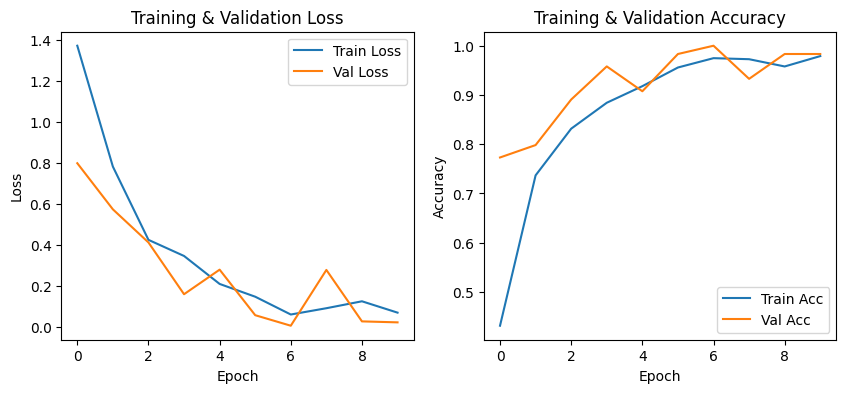

In [11]:
# Run training for multiple epochs and track losses/accuracies
def train(epochs=10):
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        tr_loss, tr_acc = train_one_epoch(train_loader)   # Train
        val_loss, val_acc = evaluate(val_loader)          # Validate

        # Save metrics for later plotting
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"train_loss={tr_loss:.4f}, acc={tr_acc:.3f}; "
              f"val_loss={val_loss:.4f}, acc={val_acc:.3f}")

    return history


# Run training
history = train(epochs=10)

# Plot training curves
plt.figure(figsize=(10,4))

# Plot loss
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


# Checkpoints

Checkpoints are necessary when the session is restarted, and thus, model state is refreshed.

It is not necessary while the session is continuing. Saving checkpoints are always recommended as new weights (even after fresh training), often give different predictions.

In [12]:
# Save only model weights
torch.save(model.state_dict(), "checkpoints/video_cnn.pth")

# Load weights
model = VideoCNN(num_classes).to(device)
model.load_state_dict(torch.load("checkpoints/video_cnn.pth", map_location=device))

<All keys matched successfully>

# Testing

In [13]:
#Evaluate on Test Set
@torch.no_grad()
def test_model(loader):
    model.eval()
    all_preds, all_labels = [], []

    for X, y in tqdm(loader, desc="Testing", leave=False):
        X, y = X.to(device), y.to(device)
        out = model(X)
        preds = out.argmax(dim=1) # No need to calculate loss, only class predictions are needed

        all_preds.extend(preds.cpu().numpy()) # Detach to CPU and convert to numpy array for further computations
        all_labels.extend(y.cpu().numpy()) # Detach to CPU and convert to numpy array for further computations

    return np.array(all_labels), np.array(all_preds)


y_true, y_pred = test_model(test_loader)


# Step 5: Result Analysis

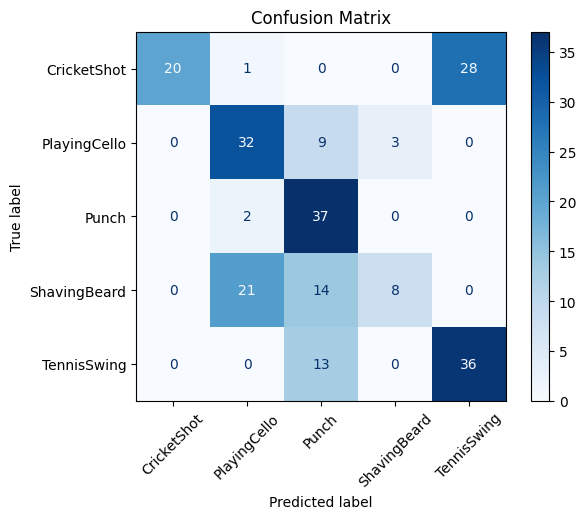


Classification Report:
              precision    recall  f1-score   support

 CricketShot       1.00      0.41      0.58        49
PlayingCello       0.57      0.73      0.64        44
       Punch       0.51      0.95      0.66        39
ShavingBeard       0.73      0.19      0.30        43
 TennisSwing       0.56      0.73      0.64        49

    accuracy                           0.59       224
   macro avg       0.67      0.60      0.56       224
weighted avg       0.68      0.59      0.56       224



In [14]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=list(test_ds.label2idx.keys()))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_ds.label2idx.keys())))

Select some random video and check the class

In [28]:
import random

def predict_random_video(test_ds, model, device, save_path, fps=16):
    """
    Pick a random video from test dataset, run prediction, and display it.
    """
    # Pick random sample
    idx = random.randint(0, len(test_ds) - 1)
    video, label = test_ds[idx]   # (C, T, H, W), int label

    # Prepare input
    video_input = video.unsqueeze(0).to(device)

    # Run model prediction
    model.eval()
    with torch.no_grad():
        out = model(video_input)
        pred = out.argmax(dim=1).item()

    # true and predicted labels
    true_label = test_ds.idx2label[label]
    pred_label = test_ds.idx2label[pred]

    # Save & display video
    vid_display = save_video(video, path=save_path, fps=fps)
    # Print results
    print(f"True label: {true_label}")
    print(f"Predicted label: {pred_label}")


save_path = "test_video.mp4"
predict_random_video(test_ds, model, device, save_path)
display_video(save_path)

Saving 16 frames of size (112, 112)
Video saved at test_video.mp4
True label: PlayingCello
Predicted label: PlayingCello
